***
## In this notebook. I have tried different parametric and non-parametric models to predict number of clicks based on characterstics of hotels. I have added some additional features for better predictions.
   
   

1. Feature Engineering: I have added following features

     - Number of Hotels (n_hotels): Number of hotels affect the chances of clicking on hotel offers (More choices of offers then number of clicks distributes between those offers)

     - Promotion: If price of hotel compared to hotels of same category ('stars') within same cities is less, tha flag promotion as 1 and vice versa
     
     - Hotel Popularity (hotel popularity from comparable number of reviews): ratio of number_of_reviews(n_reviews)/avg(n_reviews) from hotels of same category ('stars') within same cities.
     
2. Scaling of features: Since I did not have idea which features should be given more weightage, I have scaled the features so that no feature should dominate other feature (when underlying model use some kind of euclidean distance). However, I also used scaled features in tree based models which do not require scaled features. Nevertheless, algorithm converges faster.
     
3. Parametric Model: "Linear Regression" (The idea of using this model was to check if simple parametric model can be fit with given dataset (to get complexity of the problem))

     - The "NWMSE" of this model is 1.04
     
     - Assumption: I convert predictions less than 0.9 to 0.

     - High error might be due to violation of model assumptions:
         
         - NO Linear relationship
         - High Multicollinearity: Independent variables are highly positive correlated 
         - High variance of residuals: varaince of residuals changes with fitted line
         - Non-Normality of residuals: Might be due to outliers
         
     - Let's keep this error as benchmark and try different models.
         
4. "Support Vector Regressor with kernel trick" to get an intution if Non-Linear model could fit data better than linear model.

     - I tried it. It was running endlessly. I stopped it.

5. Non-Parametric Model: Random Forest
     - I have used Randomized search with cross validation to find the best parameters
     
     - The "NWMSE" score comes down to 0.821 
     
     - The non-parametric,non linear model (RF) works better than.

6. Non-Parametric Model: XGBoost

     - I have used Randomized search with cross validation to find the best parameters

     - The "NWMSE" score comes down to 0.723
     
     - The non-parametric, non linear model (XGBoost) works better than RandomForest and Linear Regression.

***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

#parametric and non parametric
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

Challenges:
    1. Around 65% rows have number clicks equal to zero.
    2. Outlier cases: unexpected number of number of images and number of reviews
    3. For first run, I keep data as it is (not handling outlier cases)

***
- Normalizing features since different feature has different value range. Our model might influenced heavy by features having high values relative to other features. 

- Also, I normalize test data here. It should be normalized by mean and variance information from training data. If we build different scaler (from whole dataset together before splitting into test/train/valid data) to scale. Then it means, we add future information into explanatory variables (mean and variance)  
***

In [3]:
def normalize_features(data_train,data_valid,data_test):
    """
    This function is used to normalize features (training, validation, test data) using explanatory information (mean and variance)
    from training data.
    
    Args:
        data_train: training data
        data_valid: validation data
        data_test: test data
        
    Returns:
        normalized training, validation and test data set.
    """
    
    # Scaling features
    scaler=StandardScaler()
    scaler.fit(data_train)
    
    X_train_transform=scaler.transform(data_train)
    
    ## training model parameters are used to scale parameters in test data (i.e, model learn to classify less than 6 to class1
    ## and if we do different scaling on test data, model could predict wrong). Moreover, our test and train data are from same
    ## distribution. It does not matter even if we use different scaling.
    X_valid_transform=scaler.transform(data_valid)
    
    X_test_transform=scaler.transform(data_test)
    
    return X_train_transform,X_valid_transform,X_test_transform
    

In [4]:
def prepare_data(df_train,df_test,features):
    """
    This function is used to prepare dataset for training the model. Also, it creates validation dataset from 
    whole dataset. First it split the data into train and validation data.It also calls for 
    normalize_features function to normalize the features.
    
    Args:
        df_train: pandas dataframe for training data (divided into training and validation data)
        df_test: Pandas dataframe of test data
        features: list of features
        
    Returns:
        normalized training, validation and test data set.
    """
    
    label='n_clicks'
    X_train,X_valid,y_train,y_valid = train_test_split(df_train[features],df_train[label],train_size=0.80 ,random_state=0)
    norm_X_train,norm_X_valid,norm_X_test=normalize_features(X_train,X_valid,df_test[features])
    
    print("shape of x_train: "+str(norm_X_train.shape))
    print("shape of y_train: "+str(y_train.shape))
    print("shape of x_valid: "+str(norm_X_valid.shape))
    print("shape of y_valid: "+str(y_valid.shape))
    print("shape of x_test: "+str(norm_X_test.shape))
    
    return norm_X_train,y_train,norm_X_valid,y_valid,norm_X_test
    
    
    

In [5]:
def nwmse_metric(observed, predicted):
    """
    This function is used to compute "normalized weighted mean squared error" as defined in the case
    study description.
    
    Args:
        observed: original dependent variable (y label)
        predicted: predicted dependent variable (y label) 
        
    Returns:
        normalized training, validation and test data set.
    """
    
    sum_error = 0.0
    weight_sum=0
    for i in range(len(observed)):
        prediction_error = predicted[i] - observed[i]
        weight=math.log(observed[i]+1)+1
        sum_error += weight*(prediction_error ** 2)
        weight_sum+=weight
        
    norm_weighted_mean_squared_error = sum_error / (float(len(observed))*weight_sum)
    
    #return math.sqrt(mean_error)
    return norm_weighted_mean_squared_error

In [6]:
def randomized_search_CV(algorithm,tuned_parameters,train_x,train_y,iteration,verbose_int,jobs_int=1):
    """
    This function performs randomized search on set of features, perform cross validation and fit the data in the specified model.
    It returns best set of features.
    
    Args:
        algorithm: Model to fit
        tuned_parameters: Set of possible parameters to choose
        train_x: training data (features) 
        train_y: training label
        iteration: number of itearation to choose random set of parameters
        
    Returns:
        set of best parameters
    
    """
    
    score = 'neg_mean_squared_error'

    print("# Tuning hyper-parameters for mean_squared_error" )
    print()
     
    clf = RandomizedSearchCV(algorithm, param_distributions=tuned_parameters, cv=5,n_iter = iteration, scoring='neg_mean_squared_error',verbose=verbose_int,n_jobs=jobs_int)
    clf.fit(train_x,train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    

## Loading Data
    There is no missing values in this dataset
***

In [8]:
# Reading training & test data 
df_train=pd.read_csv('train_data_processed.csv')
df_test=pd.read_csv('test_data_processed.csv')
print('Shape Train data :',df_train.shape)
print('Shape Test data :',df_test.shape)

Shape Train data : (395760, 13)
Shape Test data : (131929, 12)


## Feature Engineering:

Let's think, what additional features could be added 

In [9]:
df_train_features=df_train.copy()
df_test_features=df_test.copy()

### Feature 1. Total Number of hotels in each city (this might affect click chances, high number of hotel offer options for user, then clicks distributed in that fashion)

In [10]:
df_train_features=df_train_features.assign(n_hotels=df_train_features.city_id.map(df_train_features.groupby('city_id')['hotel_id'].count()))
df_test_features=df_test_features.assign(n_hotels=df_test_features.city_id.map(df_test_features.groupby('city_id')['hotel_id'].count()))

### Feature 2. Relative Popularity of the hotel
How popular is the hotel in the city if group by it's stars (popular among hotels of same stars in the city)

Hotel Popularity = n_reviews/(sum of n_reviews of hotels of same stars from the same city)


In [11]:
df_train_features_intermed=df_train_features.groupby(['city_id','stars'])['n_reviews'].sum().reset_index().rename(columns={'n_reviews':'Total_reviews'})
df_test_features_intermed=df_test_features.groupby(['city_id','stars'])['n_reviews'].sum().reset_index().rename(columns={'n_reviews':'Total_reviews'})
merged_train = pd.merge(df_train_features,df_train_features_intermed, on=['city_id','stars'])
merged_test = pd.merge(df_test_features,df_test_features_intermed, on=['city_id','stars'])
df_train_features['hotel_popularity_reviews']=merged_train['n_reviews']/merged_train['Total_reviews']
df_test_features['hotel_popularity_reviews']=merged_test['n_reviews']/merged_test['Total_reviews']

### Feature 3. Promotion Flag

Idea: If avg_price of hotel is less than avg_price of the hotels from same city than it is a promotion

In [12]:
df_train_features_intermed=df_train_features.groupby(['city_id','stars'])['avg_price'].mean().reset_index().rename(columns={'avg_price':'area_star_avg_price'})
df_test_features_intermed=df_test_features.groupby(['city_id','stars'])['avg_price'].mean().reset_index().rename(columns={'avg_price':'area_star_avg_price'})
merged_train = pd.merge(df_train_features,df_train_features_intermed, on=['city_id','stars'])
merged_test = pd.merge(df_test_features,df_test_features_intermed, on=['city_id','stars'])
df_train_features['price_diff']=merged_train['avg_price'] - merged_train['area_star_avg_price']
df_test_features['price_diff']=merged_test['avg_price'] - merged_test['area_star_avg_price']
df_train_features['promotion'] = np.where(df_train_features['price_diff']>0, 1, 0)
df_test_features['promotion'] = np.where(df_test_features['price_diff']>0, 1, 0)

## Outlier Handling

In [13]:
df_train_features['n_images_outlier'] = np.where(df_train_features['n_images']>df_train_features['n_images'].std()*2, df_train_features['n_images'].std()*2, df_train_features['n_images'])
df_test_features['n_images_outlier'] = np.where(df_test_features['n_images']>df_test_features['n_images'].std()*2, df_test_features['n_images'].std()*2, df_test_features['n_images'])

df_train_features['n_reviews_outlier'] = np.where(df_train_features['n_reviews']>df_train_features['n_reviews'].std()*2, df_train_features['n_reviews'].std()*2, df_train_features['n_reviews'])
df_test_features['n_reviews_outlier'] = np.where(df_test_features['n_reviews']>df_test_features['n_reviews'].std()*2, df_test_features['n_reviews'].std()*2, df_test_features['n_reviews'])

df_train_features['distance_to_center_outlier'] = np.where(df_train_features['distance_to_center']>df_train_features['distance_to_center'].std()*2, df_train_features['distance_to_center'].std()*2, df_train_features['distance_to_center'])
df_test_features['distance_to_center_outlier'] = np.where(df_test_features['distance_to_center']>df_test_features['distance_to_center'].std()*2, df_test_features['distance_to_center'].std()*2, df_test_features['distance_to_center'])

## Model Building 
***

***
Starting with a linear model to understand the complexity of the problem to see if a line can fit the data well or not. I fit some linear model and non linear models with default hyperparameter setttng to undertsnd if problem is linear or non-linear. Once we see if linear/non-linear could explain the problem better then we can playaround with different hyperparameters to get better predictions.

***
### Linear Regression: 
***

In [27]:
from sklearn.linear_model import LinearRegression

tuned_parameters = {'fit_intercept':[True,False], 
                    'normalize':[True,False], 
                    'copy_X':[True, False]}

features=['content_score', 'n_images_outlier', 'distance_to_center_outlier', 'avg_rating', 'stars', 'n_reviews_outlier', 'avg_rank','avg_price','avg_saving_percent','n_hotels','hotel_popularity_reviews','promotion']

norm_X_train,y_train,norm_X_valid,y_valid,norm_X_test=prepare_data(df_train_features.fillna(0),df_test_features.fillna(0),features)  
randomized_search_CV(LinearRegression(),tuned_parameters,norm_X_train,y_train,10,5,1)


shape of x_train: (316608, 12)
shape of y_train: (316608,)
shape of x_valid: (79152, 12)
shape of y_valid: (79152,)
shape of x_test: (131929, 12)
# Tuning hyper-parameters for mean_squared_error

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV]  copy_X=True, fit_intercept=True, normalize=True, score=-13277.225668659068, total=   0.1s
[CV] copy_X=True, fit_intercept=True, normalize=True .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  copy_X=True, fit_intercept=True, normalize=True, score=-12882.234783967644, total=   0.1s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV]  copy_X=True, fit_intercept=True, normalize=True, score=-16049.898364995817, total=   0.1s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV]  copy_X=True, fit_intercept=True, normalize=True, score=-15009.905690041036, total=   0.1s
[CV] copy_X=True, fit_intercept=True, normalize=True .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV]  copy_X=True, fit_intercept=True, normalize=True, score=-13799.872206993992, total=   0.1s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV]  copy_X=True, fit_intercept=True, normalize=False, score=-13277.225668659068, total=   0.1s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV]  copy_X=True, fit_intercept=True, normalize=False, score=-12882.234783967644, total=   0.1s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV]  copy_X=True, fit_intercept=True, normalize=False, score=-16049.898364995819, total=   0.1s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV]  copy_X=True, fit_intercept=True, normalize=False, score=-15009.905690041036, total=   0.1s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV]  copy_X=True, fit_intercept=True, normalize=False, score=-13799.872206993992, total=   0.1s
[CV] copy_X=True, fit_intercept=False, normalize=True ..........

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.3s finished


In [30]:
features=['content_score', 'n_images_outlier', 'distance_to_center_outlier', 'avg_rating', 'stars', 'n_reviews_outlier', 'avg_rank','avg_price','avg_saving_percent','n_hotels','hotel_popularity_reviews','promotion']
norm_X_train,y_train,norm_X_valid,y_valid,norm_X_test=prepare_data(df_train_features.fillna(0),df_test_features.fillna(0),features)

model = LinearRegression(copy_X= True, fit_intercept= True, normalize= True)
model.fit(norm_X_train,y_train)
prediction1=model.predict(norm_X_valid)
prediction1[prediction1 < 0.9]=0
#print("__"*50,"\n")
#print('The R2 of the Linear Regression is',r2_score(y_valid,prediction1))
print("__"*50,"\n")
print('The MSE of the Linear Regression is',mean_squared_error(y_valid,prediction1))
#print("__"*50,"\n")
#print('The MAE of the Linear Regression is',mean_absolute_error(y_valid,prediction1))
print("__"*50,"\n")
print('The nwmse_metric of the Linear Regression is',nwmse_metric(y_valid.values,prediction1))
print("__"*50,"\n")

shape of x_train: (316608, 12)
shape of y_train: (316608,)
shape of x_valid: (79152, 12)
shape of y_valid: (79152,)
shape of x_test: (131929, 12)
____________________________________________________________________________________________________ 

The MSE of the Linear Regression is 16159.950028315048
____________________________________________________________________________________________________ 

The nwmse_metric of the Linear Regression is 1.0402603601922285
____________________________________________________________________________________________________ 



### SVR

In [64]:
from sklearn.svm import SVR

tuned_parameters = {'kernel': ['rbf'], 
                    'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100],
                    'degree':[3,4,6]}
                   

In [ ]:
features=['content_score', 'n_images_outlier', 'distance_to_center_outlier', 'avg_rating', 'stars', 'n_reviews_outlier', 'avg_rank','avg_price','avg_saving_percent','n_hotels','hotel_popularity_reviews','promotion']
norm_X_train,y_train,norm_X_valid,y_valid,norm_X_test=prepare_data(df_train_features.fillna(0),df_test_features.fillna(0),features)

model = SVR(kernel= 'rbf',verbose=10)
model.fit(norm_X_train,y_train)
prediction1=model.predict(norm_X_valid)
#print("__"*50,"\n")
#print('The R2 of the Linear Regression is',r2_score(y_valid,prediction1))
print("__"*50,"\n")
print('The MSE of the Support Vector Regressor is',mean_squared_error(y_valid,prediction1))
#print("__"*50,"\n")
#print('The MAE of the Linear Regression is',mean_absolute_error(y_valid,prediction1))
print("__"*50,"\n")
print('The nwmse_metric of the Support Vector Regressor is',nwmse_metric(y_valid.values,prediction1))
print("__"*50,"\n")

shape of x_train: (316608, 12)
shape of y_train: (316608,)
shape of x_valid: (79152, 12)
shape of y_valid: (79152,)
shape of x_test: (131929, 12)
[LibSVM]

***
### Random Forest Regression:
***

#### First choice of Hyperparameters

In [22]:
#import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# A parameter grid for RandomForestRegressor
tuned_parameters = {
        'n_estimators': [100,150,200,300,400],
        'bootstrap': [True, False],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'max_depth': [7,8,9,10]
        }
        

features=['content_score', 'n_images_outlier', 'distance_to_center_outlier', 'avg_rating', 'stars', 'n_reviews_outlier', 'avg_rank','avg_price','avg_saving_percent','n_hotels','hotel_popularity_reviews','promotion']

norm_X_train,y_train,norm_X_valid,y_valid,norm_X_test=prepare_data(df_train_features.fillna(0),df_test_features.fillna(0),features)  
randomized_search_CV(RandomForestRegressor(),tuned_parameters,norm_X_train,y_train,10,10,-1)

shape of x_train: (316608, 12)
shape of y_train: (316608,)
shape of x_valid: (79152, 12)
shape of y_valid: (79152,)
shape of x_test: (131929, 12)
# Tuning hyper-parameters for mean_squared_error

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  50 | elapsed:  6.1min remaining: 55.3min
[Parallel(n_jobs=-1)]: Done  11 out of  50 | elapsed:  7.1min remaining: 25.0min
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:  7.4min remaining: 14.4min
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:  7.7min remaining:  9.0min
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:  7.8min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:  7.8min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  7.9min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  7.9min remaining:   30.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.0min finished


Best parameters set found on development set:

{'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True, 'n_estimators': 400, 'min_samples_split': 10}

Grid scores on development set:

-17085.825 (+/-3545.953) for {'min_samples_leaf': 1, 'max_depth': 9, 'bootstrap': False, 'n_estimators': 400, 'min_samples_split': 2}
-17250.143 (+/-4432.623) for {'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False, 'n_estimators': 200, 'min_samples_split': 10}
-12062.540 (+/-2274.277) for {'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True, 'n_estimators': 400, 'min_samples_split': 10}
-12593.085 (+/-2156.531) for {'min_samples_leaf': 2, 'max_depth': 7, 'bootstrap': True, 'n_estimators': 100, 'min_samples_split': 2}
-12562.488 (+/-2179.114) for {'min_samples_leaf': 4, 'max_depth': 7, 'bootstrap': True, 'n_estimators': 100, 'min_samples_split': 2}
-12591.657 (+/-2177.844) for {'min_samples_leaf': 2, 'max_depth': 7, 'bootstrap': True, 'n_estimators': 200, 'min_samples_split': 10}
-15808.9

In [23]:
features=['content_score', 'n_images_outlier', 'distance_to_center_outlier', 'avg_rating', 'stars', 'n_reviews_outlier', 'avg_rank','avg_price','avg_saving_percent','n_hotels','hotel_popularity_reviews','promotion']
norm_X_train,y_train,norm_X_valid,y_valid,norm_X_test=prepare_data(df_train_features.fillna(0),df_test_features.fillna(0),features)

model = RandomForestRegressor(n_estimators=400,bootstrap='True',min_samples_split=10,max_depth=10,min_samples_leaf=4)
model.fit(norm_X_train,y_train)
prediction1=model.predict(norm_X_valid)
#print("__"*50,"\n")
#print('The R2 of the Linear Regression is',r2_score(y_valid,prediction1))
print("__"*50,"\n")
print('The MSE of the RandomForestRegressor is',mean_squared_error(y_valid,prediction1))
#print("__"*50,"\n")
#print('The MAE of the Linear Regression is',mean_absolute_error(y_valid,prediction1))
print("__"*50,"\n")
print('The nwmse_metric of the RandomForestRegressor is',nwmse_metric(y_valid.values,prediction1))
print("__"*50,"\n")

shape of x_train: (316608, 12)
shape of y_train: (316608,)
shape of x_valid: (79152, 12)
shape of y_valid: (79152,)
shape of x_test: (131929, 12)
____________________________________________________________________________________________________ 

The MSE of the RandomForestRegressor is 13582.000381017378
____________________________________________________________________________________________________ 

The nwmse_metric of the RandomForestRegressor is 0.8561344180764782
____________________________________________________________________________________________________ 



#### Second choice of Hyperparameters

In [15]:
tuned_parameters = {
        'n_estimators': [200,300],
        'bootstrap': [True, False],
        }


features=['content_score', 'n_images_outlier', 'distance_to_center_outlier', 'avg_rating', 'stars', 'n_reviews_outlier', 'avg_rank','avg_price','avg_saving_percent','n_hotels','hotel_popularity_reviews','promotion']

norm_X_train,y_train,norm_X_valid,y_valid,norm_X_test=prepare_data(df_train_features.fillna(0),df_test_features.fillna(0),features)  
randomized_search_CV(RandomForestRegressor(),tuned_parameters,norm_X_train,y_train,5,3,-1)

shape of x_train: (316608, 12)
shape of y_train: (316608,)
shape of x_valid: (79152, 12)
shape of y_valid: (79152,)
shape of x_test: (131929, 12)
# Tuning hyper-parameters for mean_squared_error

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  6.1min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  6.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.4min finished


Best parameters set found on development set:

{'bootstrap': True, 'n_estimators': 200}

Grid scores on development set:

-12150.826 (+/-2008.308) for {'bootstrap': True, 'n_estimators': 200}
-12152.645 (+/-2037.654) for {'bootstrap': True, 'n_estimators': 300}
-23495.796 (+/-4512.250) for {'bootstrap': False, 'n_estimators': 200}
-23522.771 (+/-4511.406) for {'bootstrap': False, 'n_estimators': 300}


In [18]:
features=['content_score', 'n_images_outlier', 'distance_to_center_outlier', 'avg_rating', 'stars', 'n_reviews_outlier', 'avg_rank','avg_price','avg_saving_percent','n_hotels','hotel_popularity_reviews','promotion']
norm_X_train,y_train,norm_X_valid,y_valid,norm_X_test=prepare_data(df_train_features.fillna(0),df_test_features.fillna(0),features)

model = RandomForestRegressor(n_estimators=200,bootstrap='True')
model.fit(norm_X_train,y_train)
prediction1=model.predict(norm_X_valid)
#print("__"*50,"\n")
#print('The R2 of the Linear Regression is',r2_score(y_valid,prediction1))
print("__"*50,"\n")
print('The MSE of the RandomForestRegressor is',mean_squared_error(y_valid,prediction1))
#print("__"*50,"\n")
#print('The MAE of the Linear Regression is',mean_absolute_error(y_valid,prediction1))
print("__"*50,"\n")
print('The nwmse_metric of the RandomForestRegressor is',nwmse_metric(y_valid.values,prediction1))
print("__"*50,"\n")

shape of x_train: (316608, 12)
shape of y_train: (316608,)
shape of x_valid: (79152, 12)
shape of y_valid: (79152,)
shape of x_test: (131929, 12)
____________________________________________________________________________________________________ 

The MSE of the RandomForestRegressor is 13568.332220455577
____________________________________________________________________________________________________ 

The nwmse_metric of the RandomForestRegressor is 0.8208031777639037
____________________________________________________________________________________________________ 



### XG Boost

In [37]:
#import xgboost as xgb
from xgboost import XGBRegressor

# A parameter grid for XGBoost
tuned_parameters = {
        'n_estimators': [150,200,300],
        'min_child_weight': [3,4],
        'gamma':  [0],
        'subsample': [ 0.7, 0.8],
        'colsample_bytree': [ 0.7, 0.8],
        'max_depth': [7,8],
        'learning_rate' : [ 0.05, 0.1]
        }

In [38]:
features=['content_score', 'n_images_outlier', 'distance_to_center_outlier', 'avg_rating', 'stars', 'n_reviews_outlier', 'avg_rank','avg_price','avg_saving_percent','n_hotels','hotel_popularity_reviews','promotion']
norm_X_train,y_train,norm_X_valid,y_valid,norm_X_test=prepare_data(df_train_features.fillna(0),df_test_features.fillna(0),features)  
randomized_search_CV(XGBRegressor(),tuned_parameters,norm_X_train,y_train,10,0,1)

# Tuning hyper-parameters for mean_squared_error

shape of x_train: (316608, 12)
shape of y_train: (316608,)
shape of x_valid: (79152, 12)
shape of y_valid: (79152,)
shape of x_test: (131929, 12)
Best parameters set found on development set:

{'learning_rate': 0.05, 'gamma': 0, 'max_depth': 8, 'colsample_bytree': 0.8, 'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 3}

Grid scores on development set:

-11195.440 (+/-1489.591) for {'learning_rate': 0.1, 'gamma': 0, 'max_depth': 8, 'colsample_bytree': 0.7, 'subsample': 0.7, 'n_estimators': 150, 'min_child_weight': 4}
-11241.382 (+/-1529.995) for {'learning_rate': 0.1, 'gamma': 0, 'max_depth': 7, 'colsample_bytree': 0.7, 'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 4}
-11197.603 (+/-1567.835) for {'learning_rate': 0.1, 'gamma': 0, 'max_depth': 7, 'colsample_bytree': 0.7, 'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 4}
-11106.935 (+/-1686.429) for {'learning_rate': 0.05, 'gamma': 0, 'max_depth': 7, 'c

In [39]:
features=['content_score', 'n_images_outlier', 'distance_to_center_outlier', 'avg_rating', 'stars', 'n_reviews_outlier', 'avg_rank','avg_price','avg_saving_percent','n_hotels','hotel_popularity_reviews','promotion']
norm_X_train,y_train,norm_X_valid,y_valid,norm_X_test=prepare_data(df_train_features.fillna(0),df_test_features.fillna(0),features)
model = XGBRegressor(n_estimators=300,max_depth=8,eta=0.05,subsample=0.7,colsample_bytree=0.8,min_child_weight=3,gamma=0)

model.fit(norm_X_train,y_train)
prediction1=model.predict(norm_X_valid)
#print("__"*50,"\n")
#print('The R2 of the Linear Regression is',r2_score(y_valid,prediction1))
print("__"*50,"\n")
print('The MSE of the XGBoost is',mean_squared_error(y_valid,prediction1))
#print("__"*50,"\n")
#print('The MAE of the Linear Regression is',mean_absolute_error(y_valid,prediction1))l
print("__"*50,"\n")
print('The nwmse_metric of the XGBoost is',nwmse_metric(y_valid.values,prediction1))
print("__"*50,"\n")



shape of x_train: (316608, 12)
shape of y_train: (316608,)
shape of x_valid: (79152, 12)
shape of y_valid: (79152,)
shape of x_test: (131929, 12)
____________________________________________________________________________________________________ 

The MSE of the XGBoost is 12339.29996349272
____________________________________________________________________________________________________ 

The nwmse_metric of the Linear Regression is 0.7467574712517664
____________________________________________________________________________________________________ 



#### Some other Hyperparameters which did'nt came from RandomizedSearch

In [47]:
features=['content_score', 'n_images_outlier', 'distance_to_center_outlier', 'avg_rating', 'stars', 'n_reviews_outlier', 'avg_rank','avg_price','avg_saving_percent','n_hotels','hotel_popularity_reviews','promotion']
norm_X_train,y_train,norm_X_valid,y_valid,norm_X_test=prepare_data(df_train_features.fillna(0),df_test_features.fillna(0),features)
model = XGBRegressor(n_estimators=300,max_depth=7,eta=0.1,subsample=0.8,colsample_bytree=0.8,min_child_weight=3)

model.fit(norm_X_train,y_train)
prediction1=model.predict(norm_X_valid)
#print("__"*50,"\n")
#print('The R2 of the Linear Regression is',r2_score(y_valid,prediction1))
print("__"*50,"\n")
print('The MSE of the XGBoost is',mean_squared_error(y_valid,prediction1))
#print("__"*50,"\n")
#print('The MAE of the Linear Regression is',mean_absolute_error(y_valid,prediction1))l
print("__"*50,"\n")
print('The nwmse_metric of the XGBoost is',nwmse_metric(y_valid.values,prediction1))
print("__"*50,"\n")


shape of x_train: (316608, 12)
shape of y_train: (316608,)
shape of x_valid: (79152, 12)
shape of y_valid: (79152,)
shape of x_test: (131929, 12)
____________________________________________________________________________________________________ 

The MSE of the XGBoost is 11945.49938706277
____________________________________________________________________________________________________ 

The nwmse_metric of the XGBoost is 0.7226584539113659
____________________________________________________________________________________________________ 



Feature ranking:
1 avg_rank, denoted by number 6: 0.18312442
2 avg_price, denoted by number 7: 0.12671965
3 n_hotels, denoted by number 9: 0.124732494
4 n_reviews_outlier, denoted by number 5: 0.11361205
5 avg_saving_percent, denoted by number 8: 0.086212166
6 distance_to_center_outlier, denoted by number 2: 0.08078569
7 content_score, denoted by number 0: 0.0729517
8 n_images_outlier, denoted by number 1: 0.06840416
9 hotel_popularity_reviews, denoted by number 10: 0.04738612
10 avg_rating, denoted by number 3: 0.047309693
11 stars, denoted by number 4: 0.041539285
12 promotion, denoted by number 11: 0.007222562


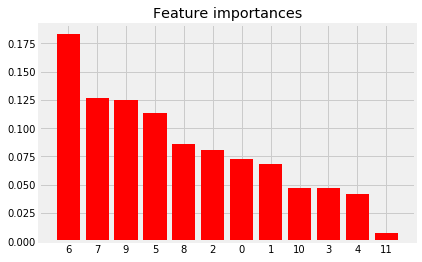

In [63]:
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(norm_X_train.shape[1]):
    #print(features[indices[f]])
    
    print(str(f+1)+" "+str(features[indices[f]])+", denoted by number "+str(indices[f])+": "+str(importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(norm_X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(norm_X_train.shape[1]), indices)
plt.xlim([-1, norm_X_train.shape[1]])
plt.show()

### Prediction for test data and saving in CSV file

In [34]:
prediction_test_data=model.predict(norm_X_test)

In [38]:
df_test_features['n_clicks']=prediction_test_data

In [39]:
df_test_features.shape

(131929, 20)

In [41]:
final_res=df_test_features[['hotel_id','n_clicks']]

In [42]:
final_res.head()

,hotel_id,n_clicks
0,14942256073,2.676275
1,16036037903,3.931976
2,288585940112,0.000000
3,129041645070,1.384049
4,12460296563,0.000000


In [44]:
final_res.shape

(131929, 2)

In [45]:
final_res.to_csv("test_data_results_bhansali.csv",index=False)

## Future Steps:
***
- Since 65% of rows have 'n_clicks' values to be 0. We can 2 models in following way:
    
    - Build a "classification model" which classifies rows as a 0 clicks or non zero clicks (lablel each row as 0 or non zero)
        
    - The rows which classification model classifies as non-zero clicks, build a "regression model" on those data to predict n_clicks.
    
- I have not used 'city_id' as of now directly in the set of features. However, we can learn embedding for the city_id's. In this way, cities with similar "hotel characterstics" will be near in feature space (similar embeddings). For example, cities with similar kind of hotels (stars) and good ratings are near in the embedding space. We could use this as one of the feature. This could be done using neural network (simple multi layer perceptron model).
        
- Some sampling techniques or weighting technique could be used to balance the dataset (zero and non-zero n_clicks) so that model is not biased to n_clicks=0.
   
- Some more features could be thought on by understanding more business domain.
   
- As of now, I have just used simple technique to remove "outliers" without business knowledge. Some other techniques like z-score (parametric model could be applied which says how many standard deviations a data point is from the sample’s mean).  
***        
        